# Comparing ELECTRA, ALBERT, DistilBERT, and TinyBERT for YouTube Comment Sentiment Analysis

---

## 1. DistilBERT: Distillation-Based Compression

**How:**  
DistilBERT uses *knowledge distillation* — training a smaller student model to mimic a larger BERT teacher.

**Why Interesting:**  
- Achieves about 40% fewer parameters and 60% faster inference while retaining around 97% of BERT’s performance.  
- Illustrates simple but effective model compression via distillation.

---

## 2. ALBERT: Parameter Sharing & Factorization

**How:**  
ALBERT reduces model size by *sharing parameters across layers* and *factorizing embeddings*.

**Why Interesting:**  
- Dramatically reduces the number of parameters without heavily impacting capacity.  
- Introduces *sentence-order prediction* to improve pretraining efficiency.  
- Shows that *architectural changes* (not just distillation) can yield compact, fast, yet strong models.

---

## 3. ELECTRA: Efficient Pretraining via Discriminators

**How:**  
ELECTRA replaces masked token prediction with a *replaced token detection* task, where a generator replaces some tokens and a discriminator predicts which tokens were replaced.

**Why Interesting:**  
- Makes pretraining more sample-efficient and faster to converge.  
- Smaller ELECTRA models often outperform comparable-sized BERTs despite using fewer compute resources during training.  
- Highlights innovation in *pretraining objectives* rather than model size or architecture alone.

---

## 4. TinyBERT: Distillation with Layer-Wise Compression

**How:**  
TinyBERT applies *knowledge distillation* focusing on both *transformer layer compression* and *embedding compression*, using a two-stage distillation from both the encoder and prediction layers.

**Why Interesting:**  
- Produces a very compact model with fewer layers (typically 4 or 6), substantially reducing size and latency.  
- Maintains strong performance close to larger BERT models on various NLP tasks including sentiment analysis.  
- Designed specifically for deployment on resource-constrained devices, balancing speed and accuracy.

---

## Why Compare These?

- They represent **complementary approaches** to making transformers faster and lighter:  
  - Distillation (DistilBERT, TinyBERT)  
  - Parameter efficiency (ALBERT)  
  - Pretraining objective redesign (ELECTRA)  
- Comparing accuracy, speed, size, and resource consumption on the same tasks reveals trade-offs important for real applications — especially on resource-restricted devices.  
- Helps practitioners **choose the best fit** for their particular constraints (e.g., mobile deployment vs. cloud inference).  
- Informs **future model design** by highlighting which efficiency techniques work best in which contexts.

# Import Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification as SeqModClf
import torch
import numpy 
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils import resample

c:\Code\College\Semester 4\Natural Language Processing\Assignment\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import transformers
print(transformers.__version__)

4.51.3


# Load Dataset

In [3]:
dataset = pd.read_csv("YoutubeCommentsDataSet.csv")

dataset.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18408 entries, 0 to 18407
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Comment    18364 non-null  object
 1   Sentiment  18408 non-null  object
dtypes: object(2)
memory usage: 287.8+ KB


The dataset has 18,408 rows and 2 columns: "Comment" (with 18,364 non-null text entries) and "Sentiment" (fully populated with sentiment labels). Both columns contain text data.

# Preprocessing

## Handle Null values

In [5]:
dataset.isnull().sum()

Comment      44
Sentiment     0
dtype: int64

In [6]:
dataset.dropna()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive
...,...,...
18403,i really like the point about engineering tool...,positive
18404,i’ve just started exploring this field and thi...,positive
18405,excelente video con una pregunta filosófica pr...,neutral
18406,hey daniel just discovered your channel a coup...,positive


# Keep only the comments in english

In [7]:
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

DetectorFactory.seed = 0

def is_english(text):
    try:
        return detect(str(text)) == "en"
    except LangDetectException:
        return False

dataset['is_english'] = dataset['Comment'].apply(is_english)
dataset = dataset[dataset['is_english']]
dataset = dataset[['Comment', 'Sentiment']]
dataset = dataset.reset_index(drop=True)

# Downscale the positive value and upscale the negative value

In [8]:
dataset['Sentiment'].value_counts()

Sentiment
positive    10642
neutral      3319
negative     2296
Name: count, dtype: int64

In [9]:
df_positive = dataset[dataset['Sentiment'] == 'positive']
df_neutral = dataset[dataset['Sentiment'] == 'neutral']
df_negative = dataset[dataset['Sentiment'] == 'negative']


df_positive_downsampled = resample(df_positive,
                                   replace=False,
                                   n_samples=3319,
                                   random_state=42)

df_negative_upsampled = resample(df_negative,
                                 replace=True,     
                                 n_samples=3319,
                                 random_state=42)

dataset = pd.concat([df_positive_downsampled, df_neutral, df_negative_upsampled])
dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

print(dataset['Sentiment'].value_counts())

Sentiment
neutral     3319
positive    3319
negative    3319
Name: count, dtype: int64


## Label Encoding
Negative = 0
Neutral = 1 
Positive = 2

To ensure consistent and clear mapping of sentiment categories to numbers across all models, which helps fairly compare their performance since they all work with the same standardized numeric labels.

In [10]:
#encode train & test
def encode_labels(dataset):
     dataset['Sentiment'] = dataset['Sentiment'].replace({'negative':0,'neutral':1,'positive':2})
     return dataset

encoded_dataset = encode_labels(dataset)

encoded_dataset.head()

C:\Users\imanu\AppData\Local\Temp\ipykernel_15608\3674117635.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['Sentiment'] = dataset['Sentiment'].replace({'negative':0,'neutral':1,'positive':2})


,Comment,Sentiment
0,seriously,1
1,when some random people are able to teach this...,1
2,841 diagram venn 1508 ds pathway 1940 role of ...,1
3,we want the blood in the streets this is actua...,2
4,i wish ethan would meet andrew tate in real li...,1


## Renaming column

In [11]:
encoded_dataset = encoded_dataset.rename(columns={'Comment': 'text', 'Sentiment': 'label'})

In [12]:
encoded_dataset.head()

,text,label
0,seriously,1
1,when some random people are able to teach this...,1
2,841 diagram venn 1508 ds pathway 1940 role of ...,1
3,we want the blood in the streets this is actua...,2
4,i wish ethan would meet andrew tate in real li...,1


## Train-test split
Allocate 30% of  data for testing and 70% for training, which provides a balanced split that allows enough data for the model to learn while reserving a sizable portion to reliably evaluate its performance on unseen examples.

In [13]:
train, test = train_test_split(encoded_dataset, test_size = 0.3, 
                               random_state = 42, 
                               stratify = encoded_dataset['label'])

train.to_csv("train.csv", index=True)
test.to_csv("test.csv", index=True)

## Conver pandas dataset to HuggingFace dataset
Hugging Face offers specialized, integrated support for transformer models, including standardized evaluation metrics, easy access to pretrained models, and streamlined training/evaluation pipelines—making model comparison more efficient, consistent, and tailored for NLP tasks than general-purpose pandas operations.

In [14]:
train_hf = Dataset.from_pandas(train.reset_index(drop= True))
test_hf = Dataset.from_pandas(test.reset_index(drop= True))

In [15]:
print(train_hf[:1])

{'text': ['anna karenina and the death of ivan ilyich are among the best books ive ever read if you do read tolstoy make sure to go with the pevear and volokhonsky translations they allow you to get the most from his works'], 'label': [2]}


In [16]:
print(test_hf[:1])

{'text': ['im gonna add myself to the many thank yous im one hour in and i already understood more than i did in a two days course i got from work you singlehandedly gave me the trust that even i can learn python and programming this video is worth gold to me right now thank you mosh'], 'label': [2]}


In [17]:
datasets = DatasetDict({ 'train': train_hf, 'test' : test_hf})

# Modelling

## DistilBERT model

### Load

In [30]:
from transformers import DistilBertTokenizer

tokenizer_distilbert = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

model = SeqModClf.from_pretrained('distilbert-base-uncased', num_labels = 3)

device  =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f'model moved to {device}')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model moved to cuda


### Tokenize

In [31]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def tokenizer_function(dataset):
    comments = [str(comment) for comment in dataset['text']]
    return tokenizer(comments, padding = 'max_length',truncation = True)

tokenized_datasets = datasets.map(tokenizer_function, batched= True)

print(tokenized_datasets['train'][0])

Map: 100%|██████████| 2988/2988 [00:00<00:00, 5345.03 examples/s]

{'text': 'anna karenina and the death of ivan ilyich are among the best books ive ever read if you do read tolstoy make sure to go with the pevear and volokhonsky translations they allow you to get the most from his works', 'label': 2, 'input_ids': [101, 4698, 8129, 3981, 1998, 1996, 2331, 1997, 7332, 6335, 10139, 2818, 2024, 2426, 1996, 2190, 2808, 4921, 2063, 2412, 3191, 2065, 2017, 2079, 3191, 2000, 4877, 29578, 2191, 2469, 2000, 2175, 2007, 1996, 21877, 3726, 2906, 1998, 5285, 6559, 8747, 5874, 11913, 2027, 3499, 2017, 2000, 2131, 1996, 2087, 2013, 2010, 2573, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

## Tokenize

In [32]:
training_args = TrainingArguments(
    output_dir = './distilbert',
    num_train_epochs = 3,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 16,
    warmup_steps = 500,
    weight_decay = 0.01,
    eval_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_f1_score',
    greater_is_better = True,
    report_to = 'none',
)

def compute_metrics(pred):
    logits, labels = pred
    predictions = numpy.argmax(logits, axis = -1)
    Accuracy_score = accuracy_score(labels,predictions)
    F1_score = f1_score(labels, predictions, average = 'weighted')
    return {'accuracy_score':Accuracy_score,'f1_score':F1_score}

trainer_distilbert = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['test'],
    tokenizer = tokenizer,
    compute_metrics = compute_metrics
)

trainer_distilbert.train()

C:\Users\imanu\AppData\Local\Temp\ipykernel_15608\1102259049.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_distilbert = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy Score,F1 Score
1,0.761400,0.535244,0.797523,0.795542
2,0.334900,0.492904,0.846720,0.845967
3,0.134400,0.661840,0.850736,0.851354


TrainOutput(global_step=2616, training_loss=0.3810840115999228, metrics={'train_runtime': 544.2904, 'train_samples_per_second': 38.411, 'train_steps_per_second': 4.806, 'total_flos': 2769545293728768.0, 'train_loss': 0.3810840115999228, 'epoch': 3.0})

## ELECTRA model

### Load

In [18]:
from transformers import ElectraTokenizer, ElectraForSequenceClassification

tokenizer_electra = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')

model_electra = ElectraForSequenceClassification.from_pretrained('google/electra-base-discriminator', num_labels=3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_electra.to(device)
print(f'Model moved to {device}')

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model moved to cuda


### Tokenize

In [19]:
def electra_tokenizer_function(dataset):
    comments = [str(comment) for comment in dataset['text']]
    return tokenizer_electra(comments, padding='max_length', truncation=True)

# Tokenize raw datasets for ELECTRA
tokenized_datasets_electra = datasets.map(electra_tokenizer_function, batched=True)

# Remove the original 'text' column
tokenized_datasets_electra = tokenized_datasets_electra.remove_columns(['text'])

# Set the format to PyTorch tensors
tokenized_datasets_electra.set_format('torch')

# Check the first tokenized example in the train split
print(tokenized_datasets_electra['train'][0])

Map: 100%|██████████| 2988/2988 [00:02<00:00, 1298.02 examples/s]

{'label': tensor(2), 'input_ids': tensor([  101,  4698,  8129,  3981,  1998,  1996,  2331,  1997,  7332,  6335,
        10139,  2818,  2024,  2426,  1996,  2190,  2808,  4921,  2063,  2412,
         3191,  2065,  2017,  2079,  3191,  2000,  4877, 29578,  2191,  2469,
         2000,  2175,  2007,  1996, 21877,  3726,  2906,  1998,  5285,  6559,
         8747,  5874, 11913,  2027,  3499,  2017,  2000,  2131,  1996,  2087,
         2013,  2010,  2573,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  

### Train

In [20]:
training_args = TrainingArguments(
    output_dir='./electra',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='eval_f1_score',
    greater_is_better=True,
    report_to='none'
)

def compute_metrics(pred):
    logits, labels = pred
    predictions = numpy.argmax(logits, axis=-1)
    Accuracy_score = accuracy_score(labels, predictions)
    F1_score = f1_score(labels, predictions, average='weighted')
    return {'accuracy_score': Accuracy_score, 'f1_score': F1_score}

trainer_electra = Trainer(
    model=model_electra,
    args=training_args,
    train_dataset=tokenized_datasets_electra['train'],
    eval_dataset=tokenized_datasets_electra['test'],
    tokenizer=tokenizer_electra,
    compute_metrics=compute_metrics
)

trainer_electra.train()

C:\Users\imanu\AppData\Local\Temp\ipykernel_15608\2713297849.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_electra = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy Score,F1 Score
1,0.763000,0.517625,0.799197,0.792671
2,0.379300,0.457086,0.860776,0.859351
3,0.176300,0.532247,0.880187,0.880611


TrainOutput(global_step=2616, training_loss=0.4010152138701273, metrics={'train_runtime': 1106.378, 'train_samples_per_second': 18.897, 'train_steps_per_second': 2.364, 'total_flos': 5500912224439296.0, 'train_loss': 0.4010152138701273, 'epoch': 3.0})

## ALBERT model

### Load

In [21]:
from transformers import AlbertTokenizer, AlbertForSequenceClassification

tokenizer_albert = AlbertTokenizer.from_pretrained('albert-base-v2')

model_albert = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_albert.to(device)
print(f'Model moved to {device}')

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model moved to cuda


### Tokenize

In [22]:
from transformers import AutoTokenizer

# Load ALBERT tokenizer
tokenizer_albert = AutoTokenizer.from_pretrained('albert-base-v2')

def albert_tokenizer_function(dataset):
    comments = [str(comment) for comment in dataset['text']]
    return tokenizer_albert(comments, padding='max_length', truncation=True)

# Tokenize raw datasets for ALBERT
tokenized_datasets_albert = datasets.map(albert_tokenizer_function, batched=True)

# Remove the original 'text' column
tokenized_datasets_albert = tokenized_datasets_albert.remove_columns(['text'])

# Set the format to PyTorch tensors
tokenized_datasets_albert.set_format('torch')

# Check the first tokenized example in the train split
print(tokenized_datasets_albert['train'][0])

Map: 100%|██████████| 2988/2988 [00:00<00:00, 3083.59 examples/s]

{'label': tensor(2), 'input_ids': tensor([    2,  2823,  7512,  1673,    17,    14,   372,    16,  5489,    31,
          102,  3870,    50,   497,    14,   246,   964,  5568,   462,  1302,
          100,    42,   107,  1302,    20, 24239,  7452,   233,   562,    20,
          162,    29,    14,  3560,   195,   512,    17,  2250,   111, 23925,
         2397, 13610,    59,  1655,    42,    20,   164,    14,   127,    37,
           33,   693,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  

### Train

In [23]:
training_args = TrainingArguments(
    output_dir='./albert',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='eval_f1_score',
    greater_is_better=True,
    report_to='none'
)

def compute_metrics(pred):
    logits, labels = pred
    predictions = numpy.argmax(logits, axis=-1)
    Accuracy_score = accuracy_score(labels, predictions)
    F1_score = f1_score(labels, predictions, average='weighted')
    return {'accuracy_score': Accuracy_score, 'f1_score': F1_score}

trainer_albert = Trainer(
    model=model_albert,
    args=training_args,
    train_dataset=tokenized_datasets_albert['train'],
    eval_dataset=tokenized_datasets_albert['test'],
    tokenizer=tokenizer_albert,
    compute_metrics=compute_metrics
)

trainer_albert.train()

C:\Users\imanu\AppData\Local\Temp\ipykernel_15608\4073434684.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_albert = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy Score,F1 Score
1,0.822500,0.805458,0.652945,0.626613
2,0.732800,0.690717,0.724230,0.719341
3,0.531200,0.603099,0.777778,0.776898


TrainOutput(global_step=2616, training_loss=0.6909599537514036, metrics={'train_runtime': 1129.3365, 'train_samples_per_second': 18.513, 'train_steps_per_second': 2.316, 'total_flos': 499687003524096.0, 'train_loss': 0.6909599537514036, 'epoch': 3.0})

## TinyBERT model

### Load

In [24]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

okenizer_tinybert = AutoTokenizer.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')

model_tinybert = AutoModelForSequenceClassification.from_pretrained('huawei-noah/TinyBERT_General_4L_312D', num_labels=3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_tinybert.to(device)
print(f'Model moved to {device}')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model moved to cuda


### Tokenize

In [25]:
from transformers import AutoTokenizer

# Load TinyBERT tokenizer - use the appropriate TinyBERT checkpoint
tokenizer_tinybert = AutoTokenizer.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')

def tinybert_tokenizer_function(dataset):
    comments = [str(comment) for comment in dataset['text']]
    return tokenizer_tinybert(comments, padding='max_length', truncation=True, max_length=512)

# Tokenize raw datasets for TinyBERT
tokenized_datasets_tinybert = datasets.map(tinybert_tokenizer_function, batched=True)

# Remove the original 'text' column
tokenized_datasets_tinybert = tokenized_datasets_tinybert.remove_columns(['text'])

# Set the format to PyTorch tensors
tokenized_datasets_tinybert.set_format('torch')

# Check the first tokenized example in the train split
print(tokenized_datasets_tinybert['train'][0])

Map: 100%|██████████| 2988/2988 [00:00<00:00, 3506.93 examples/s]

{'label': tensor(2), 'input_ids': tensor([  101,  4698,  8129,  3981,  1998,  1996,  2331,  1997,  7332,  6335,
        10139,  2818,  2024,  2426,  1996,  2190,  2808,  4921,  2063,  2412,
         3191,  2065,  2017,  2079,  3191,  2000,  4877, 29578,  2191,  2469,
         2000,  2175,  2007,  1996, 21877,  3726,  2906,  1998,  5285,  6559,
         8747,  5874, 11913,  2027,  3499,  2017,  2000,  2131,  1996,  2087,
         2013,  2010,  2573,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  

### Train

In [26]:
# Training arguments (adjust output_dir as needed)
training_args_tinybert = TrainingArguments(
    output_dir='./tinybert',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='eval_f1_score',
    greater_is_better=True,
    report_to='none'
)

# Metrics function (same as ALBERT)
def compute_metrics(pred):
    logits, labels = pred
    predictions = numpy.argmax(logits, axis=-1)
    Accuracy_score = accuracy_score(labels, predictions)
    F1_score = f1_score(labels, predictions, average='weighted')
    return {'accuracy_score': Accuracy_score, 'f1_score': F1_score}

# Assuming you have TinyBERT-tokenized datasets
trainer_tinybert = Trainer(
    model=model_tinybert,
    args=training_args_tinybert,
    train_dataset=tokenized_datasets_tinybert['train'],
    eval_dataset=tokenized_datasets_tinybert['test'],
    tokenizer=tokenizer_tinybert,
    compute_metrics=compute_metrics
)

trainer_tinybert.train()

C:\Users\imanu\AppData\Local\Temp\ipykernel_15608\885667533.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_tinybert = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy Score,F1 Score
1,0.886000,0.581269,0.765395,0.761287
2,0.500400,0.588607,0.794511,0.788036
3,0.337400,0.601350,0.814926,0.813804


TrainOutput(global_step=2616, training_loss=0.5290130839799887, metrics={'train_runtime': 198.668, 'train_samples_per_second': 105.236, 'train_steps_per_second': 13.168, 'total_flos': 299805496888320.0, 'train_loss': 0.5290130839799887, 'epoch': 3.0})

# Evaluation

## Metrics

In [33]:
distilbert_metrics = trainer_distilbert.evaluate()
print("DistilBERT eval metrics:", distilbert_metrics)
electra_metrics = trainer_electra.evaluate()
print("ELECTRA eval metrics:", electra_metrics)
albert_metrics = trainer_albert.evaluate()
print("ALBERT eval metrics:", albert_metrics)
tinybert_metrics = trainer_tinybert.evaluate()
print("TinyBERT eval metrics:", tinybert_metrics)

DistilBERT eval metrics: {'eval_loss': 0.6618396043777466, 'eval_accuracy_score': 0.8507362784471219, 'eval_f1_score': 0.8513544995260339, 'eval_runtime': 20.851, 'eval_samples_per_second': 143.302, 'eval_steps_per_second': 8.968, 'epoch': 3.0}


ELECTRA eval metrics: {'eval_loss': 0.5322473049163818, 'eval_accuracy_score': 0.8801874163319946, 'eval_f1_score': 0.8806113089944043, 'eval_runtime': 43.931, 'eval_samples_per_second': 68.016, 'eval_steps_per_second': 4.257, 'epoch': 3.0}


ALBERT eval metrics: {'eval_loss': 0.6030990481376648, 'eval_accuracy_score': 0.7777777777777778, 'eval_f1_score': 0.7768983419917441, 'eval_runtime': 47.193, 'eval_samples_per_second': 63.314, 'eval_steps_per_second': 3.962, 'epoch': 3.0}


TinyBERT eval metrics: {'eval_loss': 0.6013495326042175, 'eval_accuracy_score': 0.8149263721552878, 'eval_f1_score': 0.8138042383855054, 'eval_runtime': 8.471, 'eval_samples_per_second': 352.733, 'eval_steps_per_second': 22.075, 'epoch': 3.0}


In [34]:
data = {
    "Model": ["DistilBERT", "ELECTRA", "ALBERT", "TinyBERT"],
    "Accuracy": [
        distilbert_metrics.get("eval_accuracy_score"),
        electra_metrics.get("eval_accuracy_score"),
        albert_metrics.get("eval_accuracy_score"),
        tinybert_metrics.get("eval_accuracy_score"),
    ],
    "F1 Score": [
        distilbert_metrics.get("eval_f1_score"),
        electra_metrics.get("eval_f1_score"),
        albert_metrics.get("eval_f1_score"),
        tinybert_metrics.get("eval_f1_score"),
    ],
}

df_metrics = pd.DataFrame(data)
print(df_metrics)

        Model  Accuracy  F1 Score
0  DistilBERT  0.850736  0.851354
1     ELECTRA  0.880187  0.880611
2      ALBERT  0.777778  0.776898
3    TinyBERT  0.814926  0.813804


## Plot chart

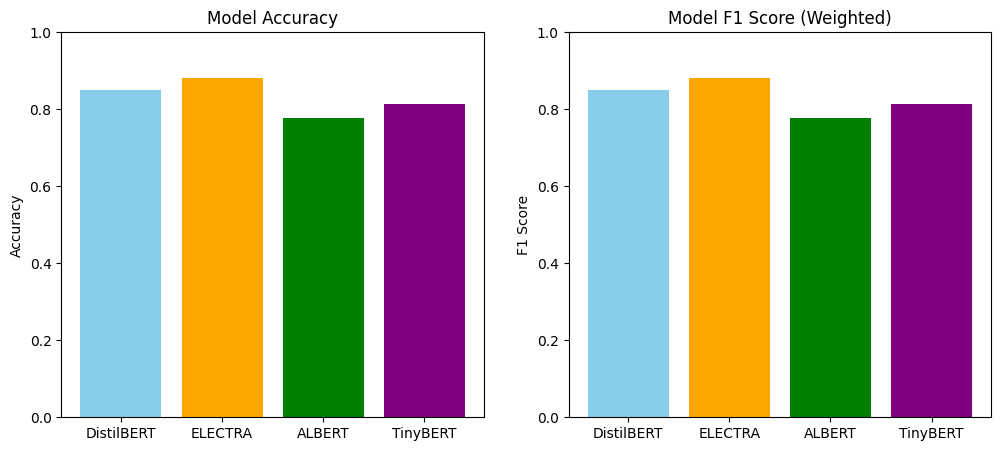

In [35]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Added one more color for TinyBERT
colors = ["skyblue", "orange", "green", "purple"]  # customize as you like

axes[0].bar(df_metrics["Model"], df_metrics["Accuracy"], color=colors)
axes[0].set_title("Model Accuracy")
axes[0].set_ylim(0, 1)
axes[0].set_ylabel("Accuracy")

axes[1].bar(df_metrics["Model"], df_metrics["F1 Score"], color=colors)
axes[1].set_title("Model F1 Score (Weighted)")
axes[1].set_ylim(0, 1)
axes[1].set_ylabel("F1 Score")

plt.show()

## Best model based on F1-score
Comparing models based on F1-score is ideal because it balances precision and recall, providing a more comprehensive measure of performance—especially for imbalanced datasets—than accuracy alone.

In [36]:
# Find the best model name based on F1 Score
best_model_name = df_metrics.loc[df_metrics['F1 Score'].idxmax(), 'Model']

# Map model name to your actual model object
model_map = {
    'DistilBERT': trainer_distilbert.model,
    'ELECTRA': trainer_electra.model,
    'ALBERT': trainer_albert.model,
    'TinyBERT': trainer_tinybert.model  
}

# Save the best model to variable 'model'
model = model_map[best_model_name]

# Get row with best model metrics
best_metrics = df_metrics[df_metrics['Model'] == best_model_name].iloc[0]

print(f"Conclusion: The best model is **{best_model_name}** "
      f"with an F1 Score of {best_metrics['F1 Score']:.4f} "
      f"and an Accuracy of {best_metrics['Accuracy']:.4f}.")

print(f"Saved the best model ({best_model_name}) to variable 'model'.")

Conclusion: The best model is **ELECTRA** with an F1 Score of 0.8806 and an Accuracy of 0.8802.
Saved the best model (ELECTRA) to variable 'model'.


# Save model

In [38]:
model.save_pretrained('./bestModel/youtube-sentiment-model')
tokenizer.save_pretrained('./bestModel/youtube-sentiment-model')

('./bestModel/youtube-sentiment-model\\tokenizer_config.json',
 './bestModel/youtube-sentiment-model\\special_tokens_map.json',
 './bestModel/youtube-sentiment-model\\vocab.txt',
 './bestModel/youtube-sentiment-model\\added_tokens.json',
 './bestModel/youtube-sentiment-model\\tokenizer.json')

# Inference

In [ ]:
from transformers import pipeline

sentiment_classifier = pipeline(
    'sentiment-analysis',
    model='./bestModel/youtube-sentiment-model',
    tokenizer='./bestModel/youtube-sentiment-model',
    device=0 if torch.cuda.is_available() else -1
)

HFValidationError: Repo id must be in the form 'repo_name' or 'namespace/repo_name': '/kaggle/working/youtube-sentiment-model'. Use `repo_type` argument if needed.

In [ ]:
new_comments = [
    "This tutorial is fantastic and extremely helpful!",
    "I'm a bit confused by some parts of this explanation.",
    "The content is decent, not particularly good or bad."
]

predictions = sentiment_classifier(new_comments)

for comment, prediction in zip(new_comments, predictions):
    print(f"Comment: \"{comment}\"")
    predicted_label_str = prediction['label']  # e.g. 'LABEL_0'
    predicted_label_int = int(predicted_label_str.split('_')[-1])
    confidence = prediction['score']
    print(f"Predicted Sentiment Label: {predicted_label_int} (Confidence: {confidence:.4f})\n")